## Data Pre-Processing:

**Step 1: Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz as gp
from sklearn.tree import DecisionTreeRegressor
sns.reset_orig()

**Step 2: Read File**

In [3]:
df_1=pd.read_csv('Previous_Closure_Data.csv')

**Step 3: Drop Unnecessary Columns**

* EmployeeNumber, EmployeeCount, Over18 and StandardHours do not give us any valuable information

In [82]:
df_1.drop(['EmployeeNumber','EmployeeCount','Over18','StandardHours'],axis=1,inplace=True)

**Step 4: Checking for Null Values and Imputing**

* Dropping null values in df_1 implies dropping null values in df_2 which leads to significant loss of employee data
* Removing column Age (having maximum null values) affected the accuracy score, hence age is an important variable
* As a result, decided to go for imputation
* Imputed numerical categories with mean and categorical categories with mode

In [83]:
df_1.isna().sum()
df_1['Age'] = df_1['Age'].fillna(df_1['Age'].mean())
df_1['DailyRate'] = df_1['DailyRate'].fillna(df_1['DailyRate'].mean())
df_1['DistanceFromHome'] = df_1['DistanceFromHome'].fillna(df_1['DistanceFromHome'].mean())
df_1['BusinessTravel'] = df_1['BusinessTravel'].fillna(df_1['BusinessTravel'].mode()[0])
df_1['MaritalStatus'] = df_1['MaritalStatus'].fillna(df_1['MaritalStatus'].mode()[0])

**Step 5: Check Duplicates:**

In [84]:
df_1.duplicated().any()

False

**Step 6: Check for Outliers:**

* While the boxplots show clear presence of outliers, on further analysing the data it came to by notice that they might not be actual outliers. One example is given below. Stock Option Level is measured on a scale of one to three and the box plot identifies three as a outlier, while it is not, logically. The same process was repeated for all variables. Overall, no *outliers* were identified/removed.

<AxesSubplot:xlabel='StockOptionLevel'>

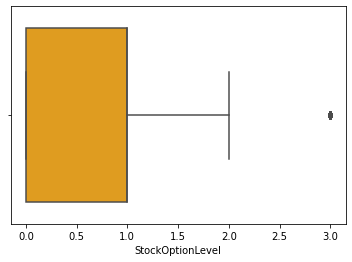

In [85]:
sns.boxplot(df_1['StockOptionLevel'],color='orange')

**Step 7: Feature Engineering Variables**

In [86]:
#Gender:

df_1 = pd.get_dummies(df_1, columns = ['Gender'])

#Dropping Gender_Female as 0 for Gender_Male means the person is a female
df_1=df_1.drop(["Gender_Female"], axis = 1)

In [87]:
#OverTime:

df_1 = pd.get_dummies(df_1, columns = ['OverTime'])

#Dropping Overtime_No as 0 for Overtime_Yes means the person has not done overtime:
df_1=df_1.drop(["OverTime_No"], axis = 1)

In [88]:
#Attrition:

df_1 = pd.get_dummies(df_1, columns = ['Attrition'])

#Dropping Attrition_No as 0 for Attrition_Yes means the person had not left the company:
df_1=df_1.drop(["Attrition_No"], axis = 1)
df_1.rename(columns={'Attrition_Yes':'Attrition'},inplace=True)

In [89]:
#Business_Travel:

#Combining categories:
df_1['BusinessTravel'] = np.where(df_1['BusinessTravel']!=('Non-Travel'), 'Yes', 'No')

df_1 = pd.get_dummies(df_1, columns = ['BusinessTravel'])

#Dropping BusinessTravel_No as 0 in BusinessTravel_Yes means the person did not travel
df_1=df_1.drop(["BusinessTravel_No"], axis = 1)

In [90]:
#Education_Field:

#Combining rare category (Human Resources):
df_1['EducationField']=df_1.EducationField.replace({'Human Resources':'Other'})

df_1 = pd.get_dummies(df_1, columns = ['EducationField'])

In [91]:
#Marital_Status, Department, Jobrole:

df_1 = pd.get_dummies(df_1, columns = ['MaritalStatus','Department','JobRole'])

In [92]:
#Combining Multiple Features:
df_1['Average_Satisfaction']=(df_1['RelationshipSatisfaction']+df_1['JobInvolvement']+df_1['JobSatisfaction']+df_1['EnvironmentSatisfaction']+df_1['WorkLifeBalance'])/5
df_1.drop(['RelationshipSatisfaction','JobInvolvement','JobSatisfaction','EnvironmentSatisfaction','WorkLifeBalance'],axis=1,inplace=True)

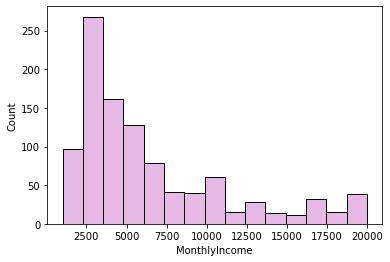

In [93]:
#Feature Tranforming MonthlyIncome:
sns.histplot(df_1['MonthlyIncome'],kde=False,bins=15,color='plum') #Not normally distributed--skewed
df_1['MonthlyIncome']=np.log(df_1['MonthlyIncome'])

## Logistic Regression:

**Step 1: Split the Dataset**

In [94]:
#Splitting and Scaling the Data: 

#Splitting the DataFrame
X= df_1.drop('Attrition', axis = 1)
Y = df_1.Attrition

#Create Training Data:
trainX, otherX, trainY, otherY = train_test_split(X, Y, test_size=0.4,random_state=100)

#Scaling Data:
Scaler = MinMaxScaler()
Scaling_Cols = ['TrainingTimesLastYear','YearsAtCompany','TotalWorkingYears','YearsInCurrentRole','YearsSinceLastPromotion','YearsWithCurrManager','PercentSalaryHike','Age','DailyRate','DistanceFromHome','HourlyRate','MonthlyIncome','MonthlyRate','NumCompaniesWorked','Average_Satisfaction']
trainX[Scaling_Cols] = Scaler.fit_transform(trainX[Scaling_Cols])
otherX[Scaling_Cols] = Scaler.transform(otherX[Scaling_Cols])

#Creating Test and Validation Data:
testX, validationX, testY, validationY = train_test_split(otherX, otherY, test_size=0.5,random_state=100)

**Step 2: Training the Model with Train Data, then Validating with Validation Data**

In [95]:
#Model Fitting and Making Predictions:

#Fitting Model:
classifier = LogisticRegression(max_iter=1000)
classifier.fit(trainX, trainY.values.ravel())

#Making Predictions with Validation Data:
y_pred = classifier.predict_proba(validationX)[:,1]

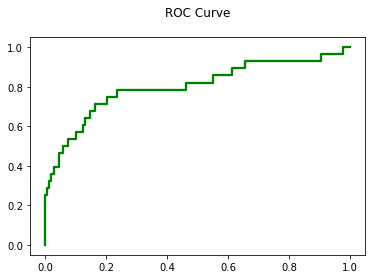

In [96]:
#ROC_Curve: 

fpr, tpr, thresholds = metrics.roc_curve(validationY,y_pred)
plt.plot(fpr, tpr, linewidth=2.3,color='green')
plt.title('ROC Curve\n')
plt.show()


In [97]:
#AUC_Score:
print('AUC: %.3f' % metrics.roc_auc_score(validationY,y_pred))

AUC: 0.802


**Step 3: Retraining the model with Training+Validation, then Testing it**

In [98]:
#Combining Train and Validation:
trainX_final=pd.concat([trainX, validationX])
trainY_final=pd.concat([trainY, validationY])

In [99]:
#Model Fitting and Making Predictions:
classifier1 = LogisticRegression().fit(trainX_final, trainY_final.values.ravel())
y_pred1 = classifier1.predict_proba(testX)[:,1]

In [100]:
#AUC Score:
print('Final AUC: %.3f' % metrics.roc_auc_score(testY,y_pred1))

Final AUC: 0.910


## Decision Tree Classifier:

**Step 1: Using Validation Dataset to choose max_leaf_nodes**

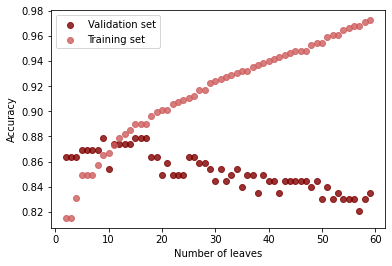

The graph suggests the number of leaf nodes to be around 9



In [101]:
# Train the model with multiple leafs:
n_max_leaf_nodes = range(2,60)
train_array = []
validation_array = []

for n in n_max_leaf_nodes:
    
    classifier_DT = DecisionTreeClassifier(max_leaf_nodes = n)
    classifier_DT = classifier_DT.fit(trainX, trainY)
    
    y_train_pred = classifier_DT.predict(trainX)
    y_validation_pred = classifier_DT.predict(validationX)
    
    train_score = accuracy_score(trainY,y_train_pred)
    validation_score = accuracy_score(validationY,y_validation_pred)

    train_array.append([n,train_score])
    validation_array.append([n,validation_score])

#Plotting:
array = pd.DataFrame(validation_array)
plt.scatter(array[0],array[1],color='Maroon',alpha=0.8)
array_train = pd.DataFrame(train_array)
plt.scatter(array_train[0],array_train[1],color='indianred',alpha=0.8)
plt.legend(['Validation set','Training set'])
plt.xlabel("Number of leaves",fontsize=10)
plt.ylabel("Accuracy",fontsize=10)
plt.show()   

print('The graph suggests the number of leaf nodes to be around 9\n')

 **Step 2: Combining Train and Validation and Fitting the Model**

In [102]:
#Combing Train and Validation:
Xtrainval=trainX.append(validationX)
ytrainval=trainY.append(validationY)

#Model Fitting with chosen max_leaf_nodes:
regressor_DT = DecisionTreeRegressor(max_leaf_nodes=9)
regressor_DT.fit(Xtrainval, ytrainval) 

DecisionTreeRegressor(max_leaf_nodes=9)

**Step 3: Prediction and Accuracy**

In [103]:
#Prediction:
y_test_pred = classifier_DT.predict(testX)

#Accuracy:    
print('Final Accuracy Score: %.3f'% accuracy_score(testY,y_test_pred))

Final Accuracy Score: 0.816


## Make Predictions:


* *Note*: Logistic Regression has given a better score (0.91) than Decision Tree Classfier. Hence, calculated predicted probabilites using Logistic Regression Model

**Step1: Read File**

In [104]:
df_2=pd.read_csv('Lyon_DataFrame.csv')

**Step 2: Drop Unnecessary Columns**

In [105]:
df_2.drop(['EmployeeNumber','EmployeeCount','Over18','StandardHours'],axis=1,inplace=True)

**Step 3: Imputation of Null Values**

In [106]:
df_2['Age'] = df_2['Age'].fillna(df_2['Age'].mean())
df_2['DailyRate'] = df_2['DailyRate'].fillna(df_2['DailyRate'].mean())
df_2['DistanceFromHome'] = df_2['DistanceFromHome'].fillna(df_2['DistanceFromHome'].mean())
df_2['BusinessTravel'] = df_2['BusinessTravel'].fillna(df_2['BusinessTravel'].mode()[0])
df_2['MaritalStatus'] = df_2['MaritalStatus'].fillna(df_2['MaritalStatus'].mode()[0])

**Step 4: Check Duplicates**

In [107]:
df_2.duplicated().any()

False

**Step 5: Feature Engineering Variables**

In [108]:
#Gender:

df_2 = pd.get_dummies(df_2, columns = ['Gender'])

#Dropping Gender_Female as 0 for Gender_Male means the person is a female
df_2=df_2.drop(["Gender_Female"], axis = 1)

In [109]:
#OverTime:

df_2 = pd.get_dummies(df_2, columns = ['OverTime'])

#Dropping Overtime_No as 0 for Overtime_Yes means the person has not done overtime:
df_2=df_2.drop(["OverTime_No"], axis = 1)

In [110]:
#Business_Travel:

#Combining categories:
df_2['BusinessTravel'] = np.where(df_2['BusinessTravel']!=('Non-Travel'), 'Yes', 'No')

df_2 = pd.get_dummies(df_2, columns = ['BusinessTravel'])

#Dropping BusinessTravel_No as 0 in BusinessTravel_Yes means the person did not travel
df_2=df_2.drop(["BusinessTravel_No"], axis = 1)

In [111]:
#Education_Field:

#Combing rare category (Human Resources):
df_2['EducationField']=df_2.EducationField.replace({'Human Resources':'Other'})

df_2 = pd.get_dummies(df_2, columns = ['EducationField'])

In [112]:
#Marital_Status, Department, Jobrole:

df_2 = pd.get_dummies(df_2, columns = ['MaritalStatus','Department','JobRole'])

In [113]:
#Combining Multiple Features:
df_2['Average_Satisfaction']=(df_2['RelationshipSatisfaction']+df_2['JobInvolvement']+df_2['JobSatisfaction']+df_2['EnvironmentSatisfaction']+df_2['WorkLifeBalance'])/5
df_2.drop(['RelationshipSatisfaction','JobInvolvement','JobSatisfaction','EnvironmentSatisfaction','WorkLifeBalance'],axis=1,inplace=True)

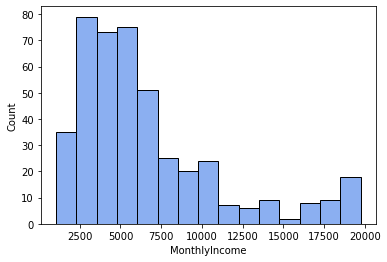

In [114]:
#Feature Tranforming MonthlyIncome:

sns.histplot(df_2['MonthlyIncome'],kde=False,bins=15,color='cornflowerblue') 
df_2['MonthlyIncome']=np.log(df_2['MonthlyIncome'])

In [115]:
#Scaling:
df_2[Scaling_Cols] = Scaler.fit_transform(df_2[Scaling_Cols])

**Step 6: Predicting Probabilities**

In [116]:
y_pred_prob = classifier1.predict_proba(df_2)[:,1]
y_pred_prob.tolist()

[0.07657588433262374,
 0.013136963554685719,
 0.4192280755768744,
 0.023974493152066113,
 0.1372282704249304,
 0.3371598529163519,
 0.30847951873473517,
 0.12048167838742649,
 0.05385577864564535,
 0.05909602872119067,
 0.5113779411119977,
 0.08284687032914385,
 0.1241798348066339,
 0.1519891577192241,
 0.05308094689938669,
 0.0664537028724481,
 0.16237391207016408,
 0.22750770753133998,
 0.14985490402118912,
 0.03897116329563202,
 0.3531798294837313,
 0.014475376785318354,
 0.06357813120540941,
 0.24079441421757278,
 0.1028145858223004,
 0.02086087815867663,
 0.1277372688130695,
 0.028880946056286546,
 0.11890765583839714,
 0.05842520472737582,
 0.02291585503143372,
 0.013878193712928925,
 0.004348371215900288,
 0.08472816576717487,
 0.48979258827325173,
 0.021568914051662457,
 0.002589690193126215,
 0.15976735739478456,
 0.8163874898632509,
 0.02111281271908203,
 0.05396346380290911,
 0.07864414455342045,
 0.06862760946651333,
 0.09799863288802219,
 0.7418248076691358,
 0.01899772647

**Step 7: Identifying Important Features**

* Overtime, Number of Companies Worked and Years Since Promotion are the top three factors in determining whether an employee will accept an RCC

In [117]:
#Creating Feature Importance DataFrame using Coeffecients:
Feature_Importance = pd.DataFrame(data={
    'Attribute': trainX_final.columns,
    'Importance': classifier1.coef_[0]
})
Feature_Importance = Feature_Importance.sort_values(by='Importance', ascending=False)

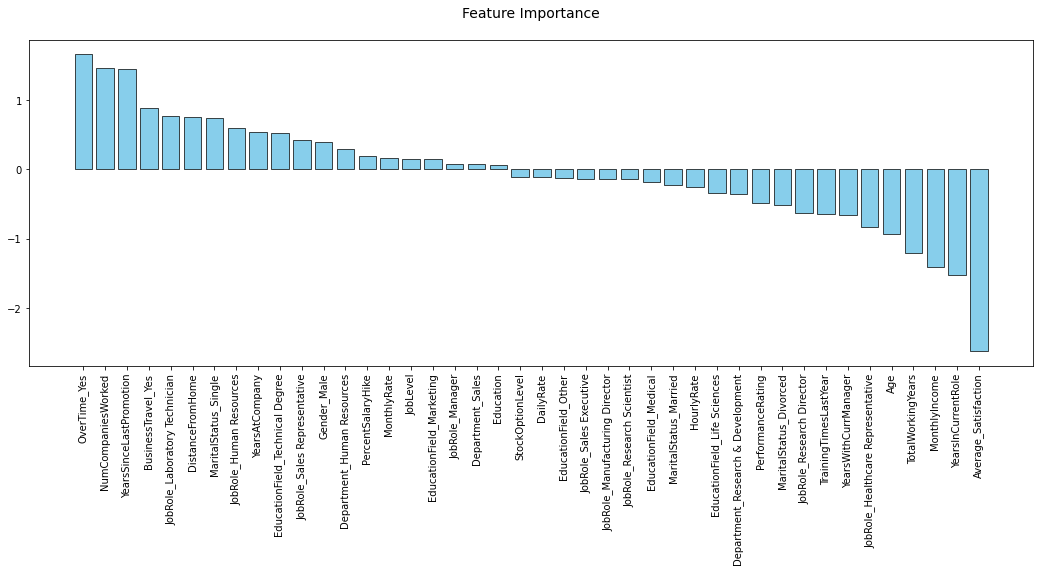

In [119]:
#Plotting:
plt.rcParams["figure.figsize"] = (18,6)
plt.rcParams.update({'axes.facecolor':'white'})
plt.gca().spines[['top','bottom','right','left']].set_color('black')
plt.bar(x=Feature_Importance['Attribute'], height=Feature_Importance['Importance'], color='skyblue',edgecolor='black',linewidth=0.7)
plt.title('Feature Importance\n', size=14)
plt.xticks(rotation='vertical')
plt.show()